In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import pandas_ta as ta

from stable_baselines3 import A2C, PPO
from stable_baselines3.common.vec_env import DummyVecEnv

from envs.Env_2 import Mult_asset_env

import matplotlib.pyplot as plt

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
Users of this version of Gym should be able to simply replace 'import gym' with 'import gymnasium as gym' in the vast majority of cases.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.


In [2]:
# assets = ['NVDA', 'AAPL', 'AMZN', 'JPM', 'IBM', 'MSFT', 'TSLA', 'GOOGL', 'META', 'HSBC']
# start_date = '2019-01-01'
# end_date = '2025-01-01'


# for symbol in assets:
#     df = yf.download(tickers = assets,
#                     start = start_date,
#                     end = end_date,
#                     interval = '1d',
#                     auto_adjust=True)
#     sta = df.stack()
#     df_flt = sta.reset_index()
#     df_flt.to_csv(f'/home/micheal/Documents/Python_Library/RL_Optimization_Portfolio/data/raw/{symbol}_daily.CSV')

In [3]:
address1 = "/home/matt/Documents/Python_Library/RL_Optimization_Portfolio-main/data/raw/AAPL_daily.CSV"

apple_df = pd.read_csv(address1,
                  parse_dates=['Date'],
                  index_col='Date',
                  engine='pyarrow',
                  dtype_backend='pyarrow'
                  )

address2 = "/home/matt/Documents/Python_Library/RL_Optimization_Portfolio-main/data/raw/MSFT_daily.CSV"

MSFT_df = pd.read_csv(address2,
                  parse_dates=['Date'],
                  index_col='Date',
                  engine='pyarrow',
                  dtype_backend='pyarrow'
                  )

apple_df['Ticker'] = 'AAPL'
MSFT_df['Ticker'] = 'MSFT'
df = pd.concat([apple_df, MSFT_df], axis=0) 

In [4]:
df

,,Ticker,Close,High,Low,Open,Volume
Date,,,,,,,
2019-01-02,0,AAPL,37.617844,37.839379,36.738855,36.896073,148158800
2019-01-03,1,AAPL,33.870834,34.711709,33.825574,34.297226,365248800
2019-01-04,2,AAPL,35.316757,35.38584,34.25435,34.428241,234428400
2019-01-07,3,AAPL,35.238152,35.452541,34.754589,35.421573,219111200
2019-01-08,4,AAPL,35.909897,36.164781,35.378693,35.626428,164101200
...,...,...,...,...,...,...,...
2024-12-24,1505,MSFT,437.647369,437.916355,432.527071,432.985301,7164500
2024-12-26,1506,MSFT,436.432068,439.251246,434.957756,437.398354,8194200
2024-12-27,1507,MSFT,428.881104,433.553144,424.71712,432.935523,18117700


In [5]:
def change (x):
    x['Ch_tomorrow'] = (x.groupby('Ticker')['Close']).pct_change(-1) * 100
    x = x.dropna().copy()
    x['Ch_direction'] = np.where(x.Ch_tomorrow > 0, 'UP', 'DOWN')

    return x


df = change(df).copy()


In [6]:
df.isna().sum()

                0
Ticker          0
Close           0
High            0
Low             0
Open            0
Volume          0
Ch_tomorrow     0
Ch_direction    0
dtype: int64

In [7]:
def normalization (x):
    
    x = x.copy()
    
    x['Log_return'] = (x.groupby('Ticker')['Close'].transform(
        lambda i: np.log( i / i.shift(1)))
    )
     
    x = x.dropna().copy()
    
    x['Log_return_Z'] = (x.groupby('Ticker')['Log_return'].transform(
        lambda i: ( i - i.mean()) /  i.std())
    )
    
    return x 

df = normalization(df).copy()

In [8]:
df

,,Ticker,Close,High,Low,Open,Volume,Ch_tomorrow,Ch_direction,Log_return,Log_return_Z
Date,,,,,,,,,,,
2019-01-03,1,AAPL,33.870834,34.711709,33.825574,34.297226,365248800,-4.094155,DOWN,-0.104924,-5.463861
2019-01-04,2,AAPL,35.316757,35.38584,34.25435,34.428241,234428400,0.22307,UP,0.041803,2.086200
2019-01-07,3,AAPL,35.238152,35.452541,34.754589,35.421573,219111200,-1.870641,DOWN,-0.002228,-0.179499
2019-01-08,4,AAPL,35.909897,36.164781,35.378693,35.626428,164101200,-1.669831,DOWN,0.018884,0.906837
2019-01-09,5,AAPL,36.519714,36.810329,35.64311,36.038533,180396400,-0.318606,DOWN,0.016839,0.801645
...,...,...,...,...,...,...,...,...,...,...,...
2024-12-23,1504,MSFT,433.583038,435.973841,431.172293,435.067322,19152500,-0.928677,DOWN,-0.003097,-0.223558
2024-12-24,1505,MSFT,437.647369,437.916355,432.527071,432.985301,7164500,0.278463,UP,0.009330,0.456044
2024-12-26,1506,MSFT,436.432068,439.251246,434.957756,437.398354,8194200,1.76062,UP,-0.002781,-0.206273


In [9]:
df.isna().sum()

                0
Ticker          0
Close           0
High            0
Low             0
Open            0
Volume          0
Ch_tomorrow     0
Ch_direction    0
Log_return      0
Log_return_Z    0
dtype: int64

In [10]:
# Features

def recommended_features(data):
            
    if isinstance(data.index, pd.MultiIndex):
        data = data.reset_index()
        
    if '' in data.columns:
        data = data.drop(columns=[''])
            
    #MA
    data['MA_10'] = data.groupby('Ticker')['Close'].transform(lambda x: x.rolling(window = 10, min_periods = 1).mean())
    data['MA_50'] = data.groupby('Ticker')['Close'].transform(lambda x: x.rolling(window = 50, min_periods = 1).mean())
    data['MA_200'] = data.groupby('Ticker')['Close'].transform(lambda x: x.rolling(window = 200, min_periods = 1).mean())
    
    #RSI
    data['RSI'] = data.groupby('Ticker')['Close'].transform(lambda x: ta.rsi(x, length = 20))

    #MACD
    data['MACD'] = data.groupby('Ticker')['Close'].transform(lambda x: x.ewm(span = 12, adjust=False).mean() - x.ewm(span = 26, adjust = False).mean())
    
    data = data.dropna().copy()
    
    #ATR
    high_low = data['High'] - data['Low']
    high_close = np.abs(data['High'] - data.groupby('Ticker')['Close'].shift())
    low_close =  np.abs(data['Low'] - data.groupby('Ticker')['Close'].shift())
    true_range = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
    
    data['TrueRange'] = true_range
    data['ATR'] = data.groupby('Ticker')['TrueRange'].transform(lambda x: x.rolling(window=14, min_periods=1).mean())
    data = data.drop(columns=['TrueRange'])
    
    return data

df = recommended_features(df)

In [11]:
print(df)
print(df.isna().sum())

           Ticker       Close        High         Low        Open     Volume  \
Date                                                                           
2019-02-01   AAPL   39.666454   40.252445   39.525909   39.771267  130672400   
2019-02-04   AAPL   40.793159   40.890826   39.847473   39.878441  125982000   
2019-02-05   AAPL   41.491123   41.705513   41.055205    41.17669  144406400   
2019-02-06   AAPL   41.505413   41.822231   41.174304   41.603076  112958400   
2019-02-07   AAPL   40.719334   41.433959   40.576407   41.067116  126966800   
...           ...         ...         ...         ...         ...        ...   
2024-12-23   MSFT  433.583038  435.973841  431.172293  435.067322   19152500   
2024-12-24   MSFT  437.647369  437.916355  432.527071  432.985301    7164500   
2024-12-26   MSFT  436.432068  439.251246  434.957756  437.398354    8194200   
2024-12-27   MSFT  428.881104  433.553144   424.71712  432.935523   18117700   
2024-12-30   MSFT  423.202911  425.91249

In [12]:
def shrinking_ings (x):
    mapping = {}
    for col in x.dtypes [x.dtypes == 'int64[pyarrow]'].index:
        max_ = x[col].max()
        min_ = x[col].min()
        if min_ < 0:
            continue
        elif max_ < 255:
            mapping[col] = 'uint8[pyarrow]'
        elif max_ < 65_535:
            mapping[col] = 'uint16[pyarrow]'
        elif max_ < 4294967295:
            mapping[col] = 'uint32[pyarrow]'
    return x.astype(mapping)

df = shrinking_ings(df)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2976 entries, 2019-02-01 to 2024-12-30
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype          
---  ------        --------------  -----          
 0   Ticker        2976 non-null   object         
 1   Close         2976 non-null   double[pyarrow]
 2   High          2976 non-null   double[pyarrow]
 3   Low           2976 non-null   double[pyarrow]
 4   Open          2976 non-null   double[pyarrow]
 5   Volume        2976 non-null   uint32[pyarrow]
 6   Ch_tomorrow   2976 non-null   double[pyarrow]
 7   Ch_direction  2976 non-null   object         
 8   Log_return    2976 non-null   float64        
 9   Log_return_Z  2976 non-null   float64        
 10  MA_10         2976 non-null   float64        
 11  MA_50         2976 non-null   float64        
 12  MA_200        2976 non-null   float64        
 13  RSI           2976 non-null   float64        
 14  MACD          2976 non-null   float64        
 15  ATR        

In [22]:
# num_assets = len(df['Ticker'].unique())
# feature_list = ['Close', 'High', 'Low', 'Open', 'Volume', 'RSI', 'MACD', 'MA_10', 'MA_50', 'MA_200']

# env = DummyVecEnv([lambda: Mult_asset_env(df=df,
#                                           num_assets=num_assets,
#                                           features_list=feature_list,
#                                           window_size=5)])
# print ("\n --- Initializing A2C Model and Starting Training ---")
# model_A2C = A2C('MlpPolicy', env, verbose=1)

# # model_A2C.learn(total_timesteps=10000)

# print('\n --- A2C Model Training Finished ---')
# print("You can now evaluate the trained model_A2C or save it for later use.")

In [15]:
unique_dates = df.index.unique()
split_date_index = int(len(unique_dates) * 0.8)
train_dates = unique_dates[:split_date_index]
test_dates = unique_dates[split_date_index:]

df_train = df[df.index.isin(train_dates)]
df_test = df[df.index.isin(test_dates)]

In [16]:
class RiskManager:
    def __init__(self, env, stop_loss_level = (0.1, 0.2)):
        self.env = env
        self.sl_1, self.sl_2 = stop_loss_level
        self.peak_prices = np.zeros(env.num_assets)
        
    def adjust_action(self, action):
        action = np.array(action, dtype=np.float32)
        if np.sum(action) <= 1e-12:
            action = np.ones_like(action) / len(action)
        else:
            action = action / np.sum(action)
            
        date = self.env.dates[self.env.current_step]
        block = self.env._daily_idx[date]
        prices = block['Close'].values.astype(np.float32)
        
        for i in range(self.env.num_assets):
            if self.env.assets_shares[i] > 0:
                self.peak_prices[i] = max(self.peak_prices[i], prices[i])
            else:
                self.peak_prices[i] = 0.0
        
        adjusted_weights = action.copy()
        for i in range(self.env.num_assets):
            if self.env.assets_shares[i] > 0 and self.peak_prices[i] > 0:
                drop_pct = (self.peak_prices[i] - prices[i]) / self.peak_prices[i]
                if drop_pct >= self.sl_2:
                    adjusted_weights[i] = 0.0
                elif drop_pct >= self.sl_1:
                    adjusted_weights[i] *= 0.5
                    
        adjusted_weights[:-1] = np.maximum(adjusted_weights[:-1], 0.0)
        total = np.sum(adjusted_weights[:-1])
        adjusted_weights[-1] = max(0.0, 1.0 - total)
        
        return adjusted_weights

In [19]:
num_assets = len(df['Ticker'].unique())
feature_list = ['Close', 'High', 'Low', 'Open', 'Volume', 'RSI', 'MACD', 'MA_10', 'MA_50', 'MA_200']

def make_train():
    return Mult_asset_env(
        df=df_train,
        num_assets=num_assets,
        features_list=feature_list,
        window_size=5,
        initial_balance=1000,
        transaction_cost_rate=0.001,
        risk_aversion=0.01,
        cash_penalty=0.1,
        invest_bonus=0.05,
        vol_window=20,
        clip_return=0.10,
        verbose=False
    )
    
def make_test():
    return Mult_asset_env(
        df=df_test,
        num_assets=num_assets,
        features_list=feature_list,
        window_size=5,
        initial_balance=1000,
        transaction_cost_rate=0.001,
        risk_aversion=0.01,
        cash_penalty=0.1,
        invest_bonus=0.05,
        vol_window=20,
        clip_return=0.10,
        verbose=True
    )


/home/matt/anaconda3/lib/python3.12/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(



 ---Initializing A2C Model and Starting Training ---
Using cpu device
------------------------------------
| time/                 |          |
|    fps                | 336      |
|    iterations         | 100      |
|    time_elapsed       | 1        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -4.3     |
|    explained_variance | 0.379    |
|    learning_rate      | 0.0007   |
|    n_updates          | 99       |
|    policy_loss        | -0.0564  |
|    std                | 1.01     |
|    value_loss         | 0.00137  |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 341      |
|    iterations         | 200      |
|    time_elapsed       | 2        |
|    total_timesteps    | 1000     |
| train/                |          |
|    entropy_loss       | -4.32    |
|    explained_variance | -6.82    |
|    learning_rate      | 0.0007   |
|   

/home/matt/anaconda3/lib/python3.12/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(



--- TEST ROLLOUT ---
[rollout] step=0 pv=999.33 cash=332.67
[env step 50] balance=1051.68, cash=350.56, shares=[1.9412293 0.9635842]
[env step 100] balance=1082.34, cash=360.78, shares=[2.0893278  0.87271404]
[env step 150] balance=1129.15, cash=376.38, shares=[1.9872028 0.8837297]
[env step 200] balance=1159.01, cash=386.33, shares=[1.7949647  0.95881593]
[env step 250] balance=1208.72, cash=402.91, shares=[1.7097636 0.967733 ]
[rollout] final_step=292 pv=1254.61 cash=418.20

--- Final Portfolio Holdings (from rollout) ---
Total value: 1254.61
Final Cash: 418.20
Weights: [0.33333451 0.33333451]
 AAPL: 1.6402 shares @ 254.97
 MSFT: 0.9751 shares @ 428.88


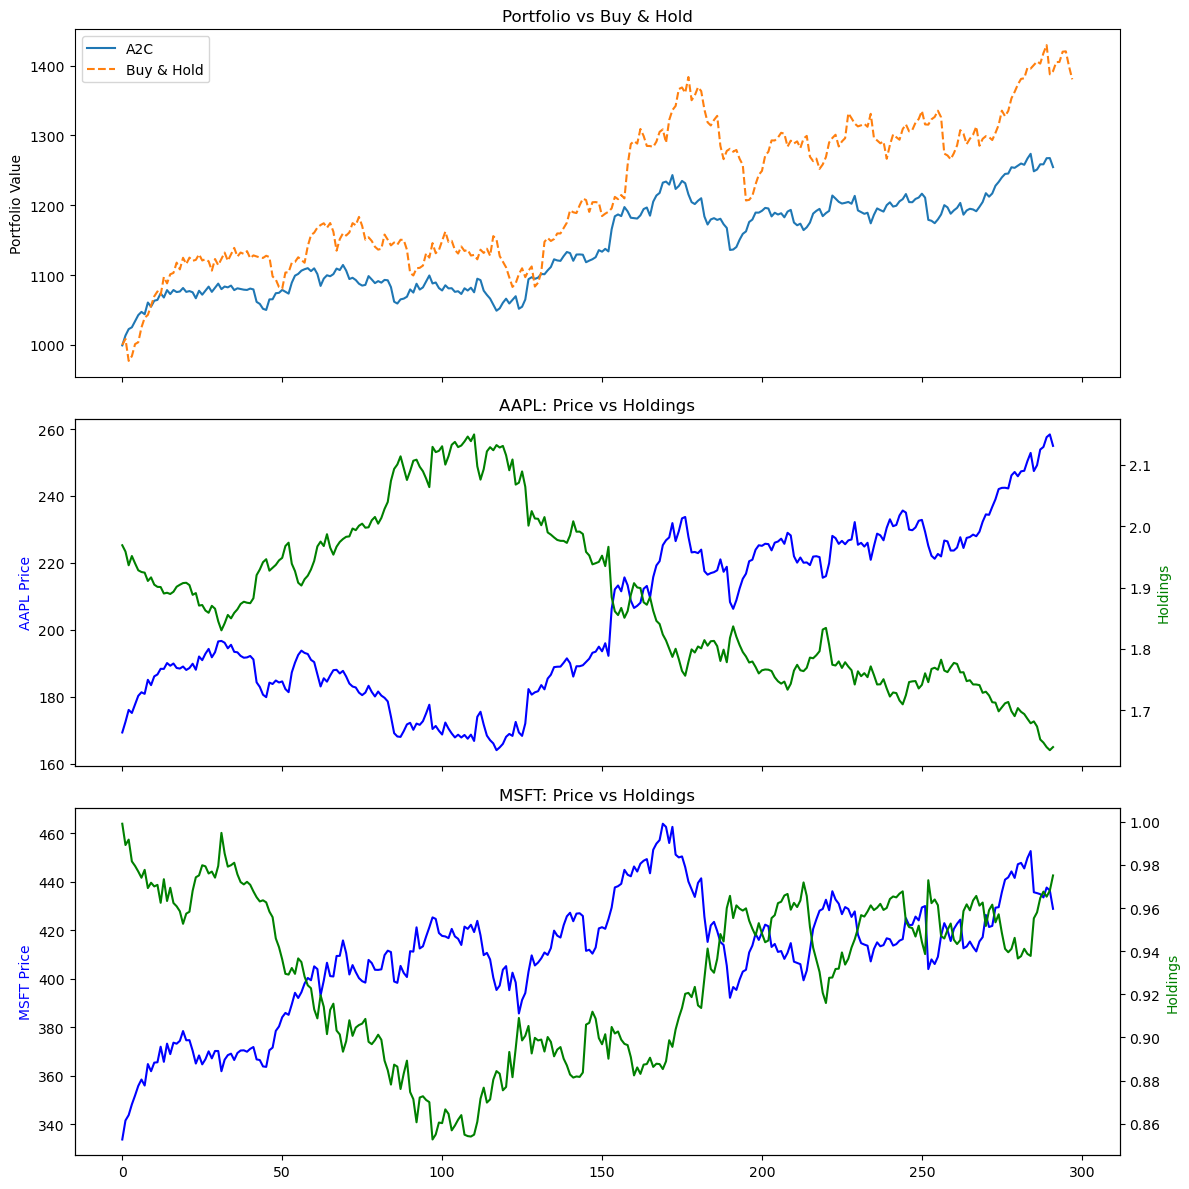

In [ ]:
train_env = DummyVecEnv([make_train])

print ('\n ---Initializing A2C Model and Starting Training ---')
model_A2C = A2C(
    'MlpPolicy', 
    train_env, 
    verbose=1, 
    gamma=0.99, 
    ent_coef=0.01,
    learning_rate=7e-4,
    device='cpu'
)

model_A2C.learn(total_timesteps=100_000)
print ('\n --- A2C Model Training Finished ---')


test_env = DummyVecEnv([make_test])

obs = test_env.reset()
# risk_manager = RiskManager(env0)

print ('\n--- TEST ROLLOUT ---')

env0 = test_env.envs[0]
max_steps = len(env0.dates) - env0.window_size + 2

portfolio_values = []
holdings_history = []
prices_history = []
steps = 0

while True:
    action, _ = model_A2C.predict(obs, deterministic=True)
    action = np.array(action).reshape(-1)

    #action = risk_manager.adjust_action(action)
    
    if action.shape[0] != num_assets + 1:
        action = np.ones(num_assets + 1, dtype=np.float32) / (num_assets + 1)
    
    obs, rewards, dones, info = test_env.step([action])

    done = bool(dones[0]) if hasattr(dones, '__len__') else bool(dones)
    if done:
        break

    if steps % 10000 == 0:
        print(f'[rollout] step={steps} pv={env0.balance:.2f} cash={env0.cash:.2f}')

    portfolio_values.append(env0.balance)
    holdings_history.append(env0.assets_shares.copy())
    prices_history.append(env0._daily_idx[env0.dates[env0.current_step-1]]['Close'].values.copy())

    steps += 1
    if steps >= max_steps:
        print('[guard] hit max_steps, breaking rollout')
        break

portfolio_values = np.array(portfolio_values)
holdings_history = np.array(holdings_history)
prices_history = np.array(prices_history)

final_env = test_env.envs[0]
tickers = final_env.tickers

final_value = portfolio_values[-1]
final_shares = holdings_history[-1]
final_prices = prices_history[-1]
final_cash = final_value - np.sum(final_shares * final_prices)

weights = (final_shares * final_prices) / final_value

print(f"[rollout] final_step={steps} pv={final_value:.2f} cash={final_cash:.2f}")

print("\n--- Final Portfolio Holdings (from rollout) ---")
print(f"Total value: {final_value:.2f}")
print(f"Final Cash: {final_cash:.2f}")
print(f"Weights: {weights}")

for i, ticker in enumerate(tickers):
    print(f" {ticker}: {final_shares[i]:.4f} shares @ {final_prices[i]:.2f}")

    
initial_cash = 1000.0

test_dates = final_env.dates
first_prices = final_env._daily_idx[test_dates[0]]['Close'].values
shares_per_asset = (initial_cash / len(tickers)) / np.array(first_prices)

bh_values = []
for d in test_dates:
    prices = final_env._daily_idx[d]['Close'].values
    bh_values.append(float(np.sum(shares_per_asset * prices)))

holdings_history = np.array(holdings_history)
prices_history = np.array(prices_history)

fig, axes = plt.subplots(num_assets + 1, 1, figsize=(12, 6 + 3*num_assets), sharex=True)


axes[0].plot(portfolio_values, label = "A2C")
axes[0].plot(bh_values, label='Buy & Hold', linestyle="--")
axes[0].set_ylabel('Portfolio Value')
axes[0].legend()
axes[0].set_title('Portfolio vs Buy & Hold')

for i, ticker in enumerate(tickers):
    ax = axes[i+1]
    ax2 = ax.twinx()
    ax.plot(prices_history[:, i], color='blue', label=f'{ticker} Price')
    ax2.plot(holdings_history[:, i], color='Green', label=f'{ticker} Holdings')
    ax.set_ylabel(f'{ticker} Price', color='blue')
    ax2.set_ylabel('Holdings', color='green')
    ax.set_title(f'{ticker}: Price vs Holdings')

fig.tight_layout()
plt.show()


/home/matt/anaconda3/lib/python3.12/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(



--- Initializing PPO Model and Starting Training ---
Using cpu device
-----------------------------
| time/              |      |
|    fps             | 374  |
|    iterations      | 1    |
|    time_elapsed    | 5    |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 359         |
|    iterations           | 2           |
|    time_elapsed         | 11          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.038945667 |
|    clip_fraction        | 0.462       |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.25       |
|    explained_variance   | -0.000214   |
|    learning_rate        | 0.0003      |
|    loss                 | 3.05e+03    |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.0651     |
|    std                  | 0.993       |
|    

/home/matt/anaconda3/lib/python3.12/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(



--- TEST ROLLOUT ---
[rollout] step=0 pv=999.83 cash=833.82
[env step 50] balance=1020.33, cash=802.09, shares=[0.88749695 0.15934199]
[env step 100] balance=1006.70, cash=829.25, shares=[1.0276712 0.       ]
[env step 150] balance=1034.03, cash=700.22, shares=[0.02622426 0.7720927 ]
[env step 200] balance=1042.39, cash=709.76, shares=[0.        0.8255259]
[env step 250] balance=1067.34, cash=629.69, shares=[0.31534842 0.8726868 ]
[rollout] final_step=292 pv=1113.32 cash=756.90

--- Final Portfolio Holdings (from rollout) ---
Total value: 1113.32
Final Cash: 756.90
Weights: [0.03884539 0.28129223]
 AAPL: 0.1696 shares @ 254.97
 MSFT: 0.7302 shares @ 428.88


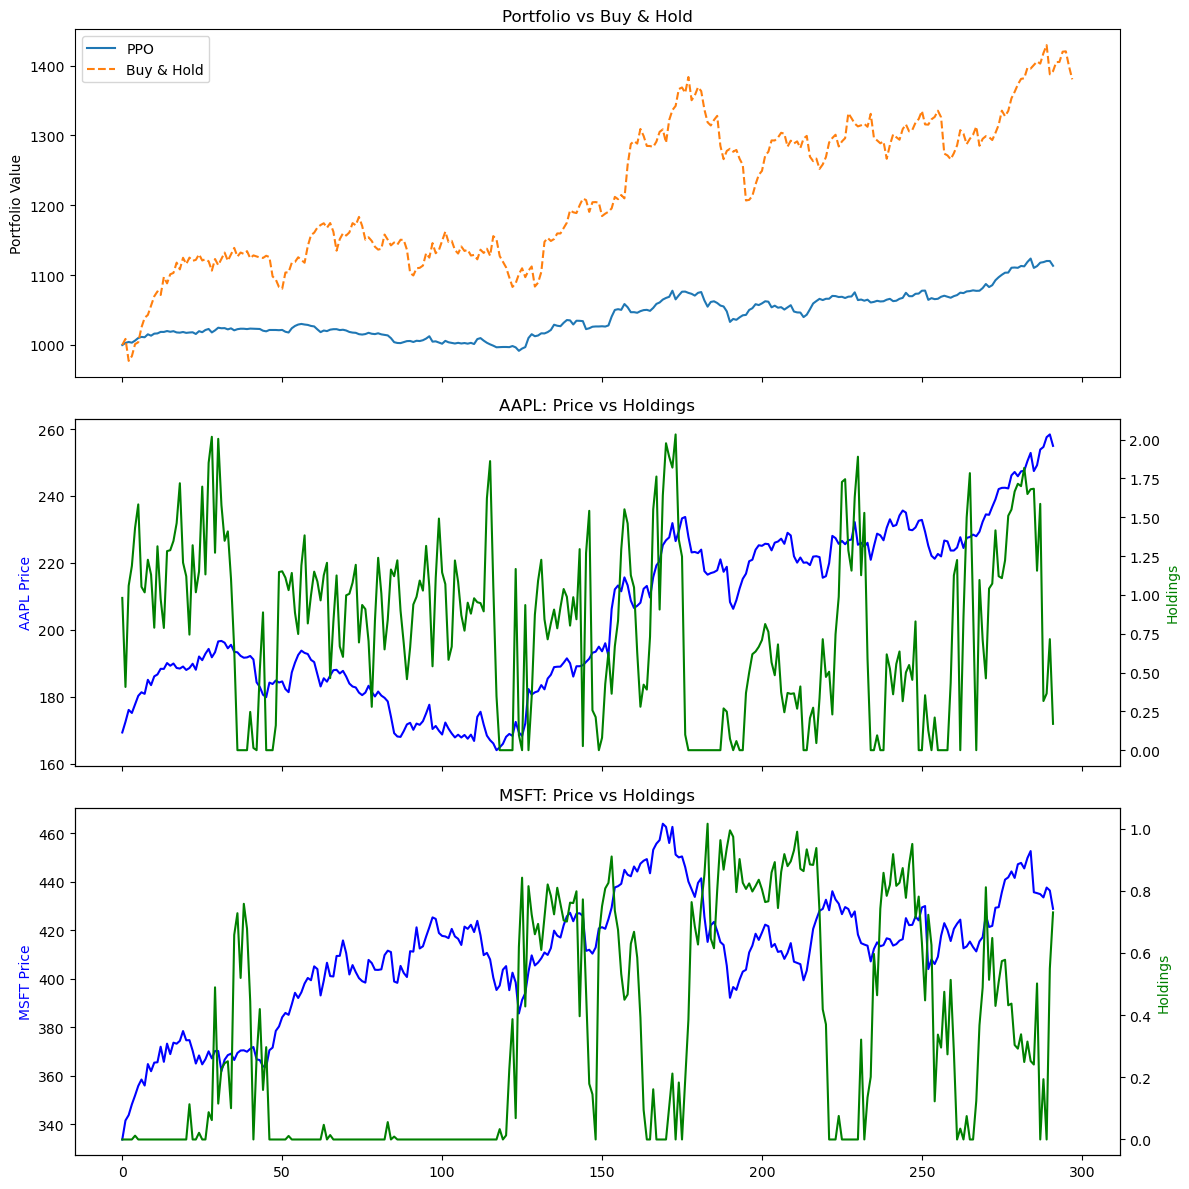

In [ ]:

# --- Training ---
train_env = DummyVecEnv([make_train])

print('\n--- Initializing PPO Model and Starting Training ---')
model_ppo = PPO(
    'MlpPolicy',
    train_env,
    verbose=1,
    gamma=0.99,
    ent_coef=0.01,
    learning_rate=3e-4,
    device='cpu'
)

model_ppo.learn(total_timesteps=100_000)
print('\n--- PPO Model Training Finished ---')

# --- Testing / Rollout ---
test_env = DummyVecEnv([make_test])
obs = test_env.reset()
env0 = test_env.envs[0]
max_steps = len(env0.dates) - env0.window_size + 2

portfolio_values = []
holdings_history = []
prices_history = []
steps = 0

print('\n--- TEST ROLLOUT ---')

while True:
    action, _ = model_ppo.predict(obs, deterministic=True)
    action = np.array(action).reshape(-1)

    
    # risk_manager = RiskManager(env0)
    # action = risk_manager.adjust_action(action)
    
    if action.shape[0] != num_assets + 1:
        action = np.ones(num_assets + 1, dtype=np.float32) / (num_assets + 1)
    
    obs, rewards, dones, info = test_env.step([action])
    
    done = bool(dones[0]) if hasattr(dones, '__len__') else bool(dones)
    if done:
        break
    
    if steps % 10000 == 0:
        print(f'[rollout] step={steps} pv={env0.balance:.2f} cash={env0.cash:.2f}')

    portfolio_values.append(env0.balance)
    holdings_history.append(env0.assets_shares.copy())
    prices_history.append(env0._daily_idx[env0.dates[env0.current_step-1]]['Close'].values.copy())
    
    steps += 1
    if steps >= max_steps:
        print('[guard] hit max_steps, breaking rollout')
        break

# --- Portfolio Summary ---
portfolio_values = np.array(portfolio_values)
holdings_history = np.array(holdings_history)
prices_history = np.array(prices_history)

final_value = portfolio_values[-1]
final_shares = holdings_history[-1]
final_prices = prices_history[-1]
final_cash = final_value - np.sum(final_shares * final_prices)
weights = (final_shares * final_prices) / final_value

print(f"[rollout] final_step={steps} pv={final_value:.2f} cash={final_cash:.2f}")
print("\n--- Final Portfolio Holdings (from rollout) ---")
print(f"Total value: {final_value:.2f}")
print(f"Final Cash: {final_cash:.2f}")
print(f"Weights: {weights}")

tickers = env0.tickers
for i, ticker in enumerate(tickers):
    print(f" {ticker}: {final_shares[i]:.4f} shares @ {final_prices[i]:.2f}")

# --- Buy & Hold Comparison ---
initial_cash = 1000.0
first_prices = env0._daily_idx[env0.dates[0]]['Close'].values
shares_per_asset = (initial_cash / len(tickers)) / np.array(first_prices)
bh_values = [float(np.sum(shares_per_asset * env0._daily_idx[d]['Close'].values)) for d in env0.dates]

# --- Plot Results ---
fig, axes = plt.subplots(num_assets + 1, 1, figsize=(12, 6 + 3*num_assets), sharex=True)
axes[0].plot(portfolio_values, label="PPO")
axes[0].plot(bh_values, label='Buy & Hold', linestyle="--")
axes[0].set_ylabel('Portfolio Value')
axes[0].legend()
axes[0].set_title('Portfolio vs Buy & Hold')

for i, ticker in enumerate(tickers):
    ax = axes[i+1]
    ax2 = ax.twinx()
    ax.plot(prices_history[:, i], color='blue', label=f'{ticker} Price')
    ax2.plot(holdings_history[:, i], color='green', label=f'{ticker} Holdings')
    ax.set_ylabel(f'{ticker} Price', color='blue')
    ax2.set_ylabel('Holdings', color='green')
    ax.set_title(f'{ticker}: Price vs Holdings')

fig.tight_layout()
plt.show()